# Vector - Technical Analysis

# **Contents**

---
* [**1. Introduction**](#1.-Introduction)
* [**2. Data Overview**](#2.-Data-Overview)
* [**3. Assumptions and Limitations**](#3.-Assumptions-and-Limitations)
* [**4. Importing Packages**](#4.-Importing-Packages)
* [**5. Defining Functions**](#5.-Defining-Functions)
* [**6. Importing Data**](#6.-Importing-Data)
* [**7. Part 1 - Determining Typical Daily Load Profiles**](#7.-Part-1---Determining-Typical-Daily-Load-Profiles)
 * [**7.1. Feature Exploration & Engineering**](#7.1.-Feature-Exploration-&-Engineering)
 * [**7.2. Modelling The Daily Residential Electricity Consumption Profile**](#7.2.-Modelling-The-Daily-Residential-Electricity-Consumption-Profile)
* [**8. Part 2 - Determine The Most benificial Customers For Insulation**](#8.-Part-2---Determine-The-Most-benificial-Customers-For-Insulation)
 * [**8.4. Electricity Consumption Difference Calculation**](#8.4.-Electricity-Consumption-Difference-Calculation)
 * [**8.5. Modelled Dependence Of Consumption On Temperature**](#8.5.-Modelled-Dependence-Of-Consumption-On-Temperature)
* [**14. Summary**](#14.-Summary)


## 1. Introduction
---
### Residential electricity load profiles

#### You have been provided an historical sample of residential smart meter load data for 50 residential customers and temperature data for Auckland for the full year 2015. Smart meters measure electricity consumption (kWh) in 30-min intervals. You have also received hourly temperature data for Auckland in 2015.

You are asked to please complete the following 2 parts of analysis:

1. The customer connections team is helping a property developer to size infrastructure for a new residential development and wants to know what the load as a group may look like and what variations may be expected. They ask you to determine typical daily load profile(s) (24 hours from midnight to midnight) for winter and summer at aggregate level. Please comment in the script on how you chose to define typical and why.

2. The customer connections team also considers asking the developer to put additional insulation into certain houses but given the current budget constraints due to COVID-19, it knows that the developer can only do this for the houses with the highest gain. Please determine the 10% of customers who will benefit the most.

## 2. Data Overview
---

### Smart Meter Load Data - 2015
---

#####  
#### Source: Provided by Vector (Marnie Simmonds)
#### File: Data_MeterSample50.csv
#####  
##### Information Overview:
 - **TradingPeriod**:  30 minute time intervals that reset each day (1-48)
 - **MeterPollDateKey**:  A date key (YYYYMMDD)
 - **ICPKey**:  Installation control point number for residential smart meters (contains unique 50 entries)
 - **ElecCons_kWh**:  Data on kilowatt hour electricity consumption within the trading period (e.g. the **ElecCons_kWh** corresponding to the **TradingPeriod** of 1 would be the the average rate of consumption between 12am and 12:30am in kWh. so a **ElecCons_kWh** of 0.2 would amount to using 0.1 kW of electricity)
 
### - Consumption reading?

### Temperature Data - 2015
---

#####  
#### Source: Provided by Vector (Marnie Simmonds)
#### File: Data_Weather2015.csv
#####  
##### Information Overview:
 - **HourStart**: Time of day in 1 hour time intervals (0-23)
 - **DateKey** : A date key (YYYYMMDD)
 - **Temp_DegCelsius**: The temperature. For this analysis, what i consider to be, the simplist interpretation will be used which is that the feature **Temp_DegCelsius** is the temperature at the start of the hour (e.g. the value corresponding to an **HourStart** of 0 is the temperture at 12am). The way that the **HourStart** feature is worded leaves me wondering if this is somthing more along the lines of the average temperature over the hour that started at 12am or even the temperature at the midpoint of the hour (e.g. the temperature at 12:30am) clarifying this would be recomended as it effects how the meter data can be joined on.

### I had a brief look for other sources of weather data as I suspect that rain and windchill factor will have a significant impact on percieved temperature and heating/cooling electricity consumption...

## 3. Assumptions and Limitations
---
      
1. Internal temperature; at this stage there is no internal temperature data. The ideal case would be the site by site thermostat readings.    The rate of heat transfer?.
 
2. Summer ends on Saturday, 21 March and winter starts on Sunday, 22 June and ends on Wednesday, 23 September and summer starts again on Monday, 22 December (source: google). This assumes that the property developer is interested in the more extreme temperature profiles.

3. Interpolating weather values...  

4. Other wheather effects...
  
5. Temperature inside the home (For part two) is energy just being consumed for heat or other reasons...

6. I've decided not to remove outliers as although some of them look very large no points look erorneuos and the variations are mentiond as being of interest

7. Insulation has a imact on electricity consumption for both heating or cooling.

8. Insulation has a reduction in energy directly proportional to the energy used for heating or cooling.

## 4. Importing Packages
---

In [1]:
# File system management
import os
# Setting the directory to the parent directory
os.chdir('..')

# Numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# Interpolate and random for data extension
from scipy import interpolate
import random

# Datetime for handling datetime variables
import datetime as dt

# Importing algorithms
# from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# from xgboost import XGBRegressor

# shap for model interpretability
import shap

# Sklearn label encoder
from sklearn.preprocessing import LabelEncoder

# Sklearn data splitting
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Sklearn importing measurement metric for temp correlation of consumption
from sklearn.metrics import mean_squared_error

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 5. Defining Functions
---

A season feature funtion

In [2]:
def season(df):
    # Basic funtion to define a summer, winter or other feature for the sothern hemisphere in 2015.
    if ((df['Date'] <= dt.date(2015, 3, 21)) | (df['Date'] >= dt.date(2015, 12, 22))):
        val = 'Summer'
    elif ((df['Date'] >= dt.date(2015, 6, 22)) & (df['Date'] <= dt.date(2015, 9, 23))):
        val = 'Winter'
    else:
        val = 'Other'
    return val

A model fitting function

In [3]:
# A cross validation model fitting function. In this case there is probably no need for cross validation as we are simply looking 
# to understand the profile but I had thif function lying around from previous projects.
def model_fit(mdl, mdl_nme='', df=None, tgt_var=None, n_fld=5, output=True):   
    # basically a verbosity condition
    if output:
        print(f"{mdl_nme} fit")
              
    # K fold validation
    fld = KFold(n_splits=n_fld, shuffle=True, random_state=42)
    
    # List of feature columns
    fts = [f for f in df.columns if f not in [tgt_var]]
    
    # Initializing Variables
    prd = np.zeros(df[fts].shape[0])
    ful_prd = np.zeros(df[fts].shape[0])
    RMSE = 0
    MSE = 0
    RMSE_tot = 0
    MSE_tot = 0
    
    for n_fold, (trn_idx, vld_idx) in enumerate(fld.split(df[fts], df[tgt_var])):
        trn_X, trn_y = df[fts].iloc[trn_idx], df[tgt_var].iloc[trn_idx]
        vld_X, vld_y = df[fts].iloc[vld_idx], df[tgt_var].iloc[vld_idx]
        # Fit the model
        mdl.fit(trn_X, trn_y)
        
        prd[vld_idx] = mdl.predict(vld_X)
            
        # Appling the fit to the prediction set
        ful_prd += mdl.predict(df[fts])/fld.n_splits

        # Outputting the AUC
        MSE = mean_squared_error(vld_y, mdl.predict(vld_X))
        MSE_tot += MSE/fld.n_splits
        RMSE = np.sqrt(MSE)
        
        # Outputting statistics
        if output:
            print('Fold %2d RMSE : %.6f' % (n_fold + 1, RMSE))
    
    RMSE_tot = np.sqrt(MSE_tot)
    if output:
        print('RMSE over folds: %.6f' % RMSE_tot)
    # Note that at this stage this only returns the model from the final fold
    return RMSE_tot, ful_prd, mdl

Custom line plot function

In [4]:
def line_plot(data, group, x='', y='', title=''):   
    plot = sns.FacetGrid(data, hue=group, height=4, aspect=4)
    plot.map(plt.plot, x, y)
    plot.fig.suptitle(title)
    plot.add_legend()

Profile plottig function

In [5]:
def profile_plot(df, fig_name=''):
    
    # Plotting the measured consumption aggregated over all 50 sampled ICPKeys
    plt.plot(df['TradingPeriod'], df['ElecCons_kWh'], 'o', color='seagreen', alpha=0.08);
    
    # Aggregating the consumtion to a average daily profile
    df = pd.DataFrame(df.groupby(['TradingPeriod'])[['5th_ElecCons_kWh', '25th_ElecCons_kWh', 'Expected_ElecCons_kWh', '75th_ElecCons_kWh', '95th_ElecCons_kWh']]
                        .mean()
                        .reset_index(level=['TradingPeriod']))
    
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['5th_ElecCons_kWh'], ':', color='mediumblue', label = "5th percential", linewidth=2)
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['25th_ElecCons_kWh'], '--', color='mediumblue', label = "25th percential", linewidth=2)
    # Plotting the best fit
    plt.plot(df['TradingPeriod'], df['Expected_ElecCons_kWh'], '-', color='black', label = "Best Fit", linewidth=2)
    # Plotting the 5th percentile
    plt.plot(df['TradingPeriod'], df['75th_ElecCons_kWh'], '--', color='mediumblue', label = "75th percential", linewidth=2)
    # Plotting the 95th percentile
    plt.plot(df['TradingPeriod'], df['95th_ElecCons_kWh'], ':', color='mediumblue', label = "95th percentile", linewidth=2)

    # Setting the title axies and legend
    plt.xlabel('Trading Period (30 min intervals)', size=14)
    plt.ylabel('Electricity Consumption (kWh)', size=14)
    plt.title(f"Daily Residential Electricity Consumption Profile - {fig_name}", size=20)
    plt.legend()

    # Display and save the figure.
    fig = plt.gcf()
    fig.set_size_inches(16, 6, forward=True)
    fig.savefig(f"figures/Electricity-Consumption-Profile-{fig_name}.png", dpi=100)

Calculate the average absolute shap value

In [ ]:
def avg_abs_shap_value(model, df, feature):
    # For info on SHAP values: https://github.com/slundberg/shap
    
    # List of feature columns
    features = [f for f in df.columns if f not in ['ElecCons_kWh']]
    X = df[features]
    y = df['ElecCons_kWh']
    
    # Fitting a random forrest regressor
    model.fit(X, y)
    
    # Calculating the average absolute shap value
    shap_values = shap.TreeExplainer(model).shap_values(X)
    shap_df = pd.DataFrame(shap_values)
    shap_df.columns = X.columns
    avg_abs_impact = shap_df[feature].abs().mean()

    return avg_abs_impact    

## 6. Importing Data
---

### Importing The Meter Sample Dataset (Data_MeterSample50.csv)

In [6]:
# Importing the meter dataset as a pandas dataframe
meter_df = pd.read_csv('data/Data_MeterSample50.csv')

In [7]:
meter_df.head()

,ICPKey,MeterPollDateKey,TradingPeriod,ElecCons_kWh
0,5972076,20150101,1,0.16
1,5972076,20150101,2,0.17
2,5972076,20150101,3,0.13
3,5972076,20150101,4,0.15
4,5972076,20150101,5,0.16


In [8]:
# Note that there is a maximum trading period of 50 which I'm assuming is because of daylight savings causing an hour to appear twice (and conversly there is probably a day that only went up to 46.
# Ideally we should create a datetime variable and adjust to UTC to acount for this shift
meter_df.describe(include='all')

,ICPKey,MeterPollDateKey,TradingPeriod,ElecCons_kWh
count,8.759500e+05,8.759500e+05,875950.000000,875950.000000
mean,6.155496e+06,2.015067e+07,24.501564,0.500849
std,2.016792e+05,3.450066e+02,13.853280,0.550925
min,5.972076e+06,2.015010e+07,1.000000,0.000000
25%,6.015713e+06,2.015040e+07,13.000000,0.119000
50%,6.033299e+06,2.015070e+07,25.000000,0.294900
75%,6.402389e+06,2.015100e+07,37.000000,0.685900
max,6.578393e+06,2.015123e+07,50.000000,5.710000


### Importing The Hourly Temperature Dataset

In [9]:
# Importing and concatenating the monthly readings
temp_df = pd.read_csv('data/Data_Weather2015.csv')

In [10]:
temp_df.head()

,DateKey,HourStart,Temp_DegCelsius
0,20150101,0,19.00
1,20150101,1,18.75
2,20150101,2,17.25
3,20150101,3,16.50
4,20150101,4,16.50


In [11]:
# Note: No additional hours from daylight savings but there will probably be a day with a repeated hour and a day with a missing hour.
temp_df.describe(include='all')

,DateKey,HourStart,Temp_DegCelsius
count,8.760000e+03,8760.000000,8760.000000
mean,2.015067e+07,11.500000,15.206117
std,3.450216e+02,6.922582,4.089467
min,2.015010e+07,0.000000,3.500000
25%,2.015040e+07,5.750000,12.250000
50%,2.015070e+07,11.500000,15.000000
75%,2.015100e+07,17.250000,18.000000
max,2.015123e+07,23.000000,26.500000


# 7. Part 1 - Determining Typical Daily Load Profiles
---

## 7.1. Feature Exploration & Engineering
---

#### Creating a Season Feature

In [12]:
# Converting the date to a datetime feature
meter_df['Date'] = pd.to_datetime(meter_df['MeterPollDateKey'], format='%Y%m%d')

In [13]:
# Creating a winter, summer and other feature
meter_df['Season'] = meter_df.apply(season, axis=1)

In [14]:
# Creating a plotable dataframe
kWh_by_season_df = pd.DataFrame(meter_df.groupby(['Season','TradingPeriod'])['ElecCons_kWh'].mean())
kWh_by_season_df.reset_index(level=['Season','TradingPeriod'], inplace=True)

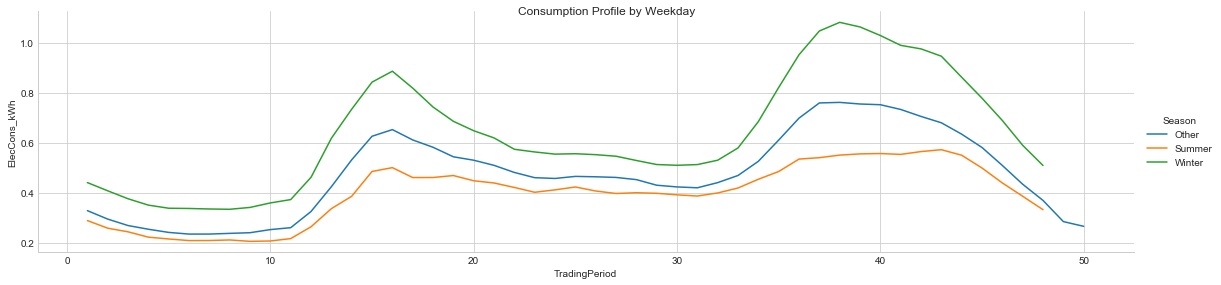

In [15]:
# Plotting the distributions of price against weekday. 
# This shows clearly different profiles with winter being the most intense consumption suggesting that electric heating or more time spent in doors might be the biggest factors.
line_plot(data=kWh_by_season_df, group='Season', x='TradingPeriod', y='ElecCons_kWh', title='Consumption Profile by Weekday')

In [16]:
# Creating a dictionary for the weekend flag
season_dict = {"Summer": 0, "Winter": 1, "Other": 2}
meter_df['Season_Int'] = meter_df['Season'].map(season_dict)

#### Creating a Weekday and Weekend Feature

In [17]:
# Creating a weekday feature
meter_df['Weekday_Int'] = (meter_df['Date'].dt
                                           .weekday)
# Creating a maping dictionary
day_dict = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",4: "Friday", 5: "Saturday", 6: "Sunday"}
meter_df['Weekday'] = meter_df['Weekday_Int'].map(day_dict) 

In [18]:
# Creating a plotable dataframe
kWh_by_weekday_df = pd.DataFrame(meter_df.groupby(['Weekday','TradingPeriod'])['ElecCons_kWh'].mean())
kWh_by_weekday_df.reset_index(level=['Weekday','TradingPeriod'], inplace=True)

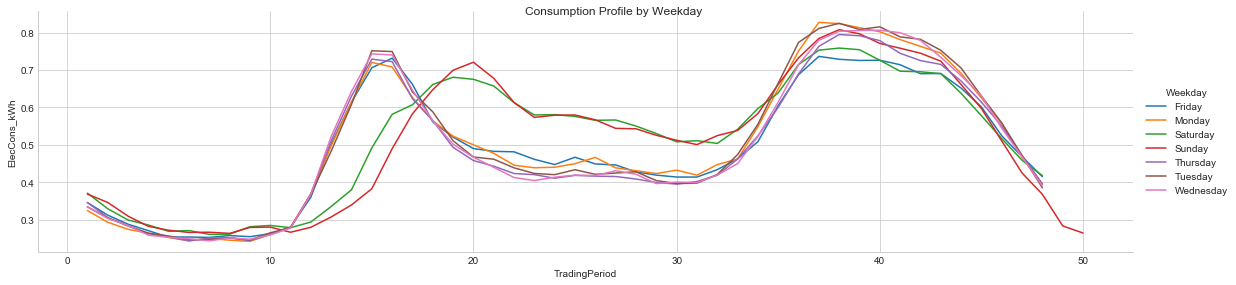

In [19]:
# Plotting the distributions of consumption against weekday
line_plot(data=kWh_by_weekday_df, group='Weekday', x='TradingPeriod', y='ElecCons_kWh', title='Consumption Profile by Weekday')

In [20]:
# Creating a dictionary for the weekend flag
weekend_dict = {"Monday": 0, "Tuesday": 0,"Wednesday": 0,"Thursday": 0,"Friday": 0,"Saturday": 1,"Sunday": 1}
meter_df['Weekend'] = meter_df['Weekday'].map(weekend_dict)

I used this feature for a quick explortion of impacts of day of the week and produced a couple profiles with the weekends seperated out and it's a significant contributer. 
Perhaps a weekday could be used as the typical profile?
Due to time constraints and to maintain simplicity I didnt explore it further.

#### Creating a Public Holiday Flag

Although I didn't get around to it I image public holidays will also display significantly different profiles (perhaps similar to weekends?).

I also expect the profiles throuhout winter ans summer will be different accouse the mounths but again I didn't explore it.

#### Creating a Month Feature

In [21]:
# Creating a month feature
meter_df['Month_Int'] = (meter_df['Date'].dt
                                         .month)
# Creating a dictionary
mo_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
meter_df['Month'] = meter_df['Month_Int'].map(mo_dict)

In [22]:
# Creating a plotable dataframe
kWh_by_month_df = pd.DataFrame(meter_df.groupby(['Month','TradingPeriod'])['ElecCons_kWh'].mean())
kWh_by_month_df.reset_index(level=['Month','TradingPeriod'], inplace=True)

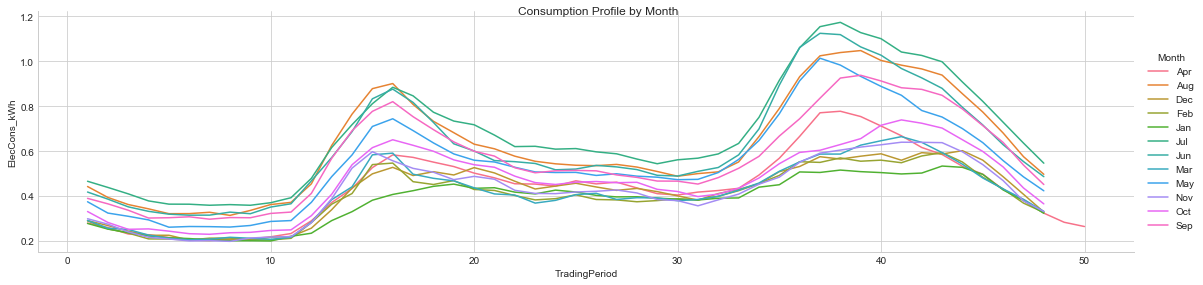

In [23]:
# Plotting the distributions of consumption against month
line_plot(data=kWh_by_month_df, group='Month', x='TradingPeriod', y='ElecCons_kWh', title='Consumption Profile by Month')

This shows significant seperation between July and Sept even though they are both winter months. Perhaps a central month of the season cold be chosen as the typical profile? The three lowest usage moths are Jan followed by Dec and Feb which is squarly in summer.

## 7.2. Modelling The Daily Residential Electricity Consumption Profile
---

#### In order to maintain some simplicity I have defined the 'typical' profile as the best fit profile over the entire winter and summer seasons.
##### I did explore the posibility of creating a subset such as seperating out weekdays from weekends and public holidays, using just a month from the center of the season, or even a day with a typical temperature profile. In the end due partly to maintaining simplicity but mostly due to the property developer wanting to understand variations I choose not to select a subset for the typical profile.

In [24]:
# Aggregating the consumtion to a total accross all 50 sampled ICPKeys
model_df = pd.DataFrame(meter_df.groupby(['MeterPollDateKey', 'TradingPeriod', 'Season_Int'])[['ElecCons_kWh']]
                                .sum()
                                .reset_index(level=['MeterPollDateKey', 'TradingPeriod', 'Season_Int'])
                                .sort_values(by=['TradingPeriod']))

In [25]:
# Selecting a simple dataset for the profile model
model_df = model_df[['TradingPeriod', 'ElecCons_kWh', 'Season_Int']]

##### The methodology applied below is based off Will Koehrsens Towards Data Science post: https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed.
##### Another article using the renouned XGBoost algorithm with a similar methodology is described by Benoit Descamps here: https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b and should be explored for profile mapping in the future.

In [26]:
# The methodology here is based off Will Koehrsens Towards Data Science post: 
# https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

# Set lower and upper quantile
lower = 0.05
upper = 0.99

# Calculate the best fit
gbr = GradientBoostingRegressor(random_state=42)
loss, expected_kWh, _ = model_fit(gbr, 'Gradient Boosting Regressor', model_df, 'ElecCons_kWh')
model_df['Expected_ElecCons_kWh'] = expected_kWh

# Calculate the lower 5th percential
gbr_5 = GradientBoostingRegressor(loss="quantile", alpha=0.05, random_state=42)
loss, kWh_5th, _ = model_fit(gbr_5, 'Lower 5 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['5th_ElecCons_kWh'] = kWh_5th

# Calculate the lower 12.5th percential
gbr_25 = GradientBoostingRegressor(loss="quantile", alpha=0.25, random_state=42)
loss, kWh_25th, _ = model_fit(gbr_25, 'Lower 25 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['25th_ElecCons_kWh'] = kWh_25th

# Calculate the upper 75th percential
gbr_75 = GradientBoostingRegressor(loss="quantile", alpha=0.75, random_state=42)
loss, kWh_75th, _ = model_fit(gbr_75, 'Upper 75 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['75th_ElecCons_kWh'] = kWh_75th

# Calculate the upper 95th percential
gbr_95 = GradientBoostingRegressor(loss="quantile", alpha=0.95, random_state=42)
loss, kWh_95th, _ = model_fit(gbr_95, 'Upper 95 Gradient Boosting Regressor', model_df, 'ElecCons_kWh', output=False)
model_df['95th_ElecCons_kWh'] = kWh_95th

Gradient Boosting Regressor fit
Fold  1 RMSE : 5.326032
Fold  2 RMSE : 5.524103
Fold  3 RMSE : 5.526477
Fold  4 RMSE : 5.625193
Fold  5 RMSE : 5.496525
RMSE over folds: 5.500525


KeyError: "Columns not found: '25th_ElecCons_kWh', '75th_ElecCons_kWh', '5th_ElecCons_kWh', 'Expected_ElecCons_kWh', '95th_ElecCons_kWh'"

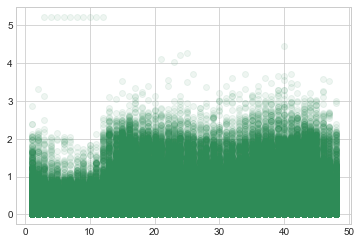

In [83]:
summer_weekday_df = model_df.where(model_df.Season_Int == 0)
profile_plot(summer_weekday_df, fig_name='Summer')

In [ ]:
winter_weekday_df = model_df.where(model_df.Season_Int == 1)
profile_plot(winter_weekday_df, fig_name='Winter')

## 14. Summary
---

# 8. Part 2 - Determine The Most benificial Customers For Insulation
---

## 8.1. Detemining A Households Dependence On Temperature
---

##### Some demographic information (number of people, age, income, other expenses, etc) should be collected about the housholds. The overall electricity consumption is not as important as the number of people and specifically how many vulnerable people (young and elderly, etc.) would be positivly impacted by insulation. There is also a strong posibility that the less welthy housholds (maybe the ones with more vulnerable people or dependents) have historically tried to save on there electricity bills and so the data, as provided, won't contain the information required to identify the people who would benifit the most. 
##### A thourougher aproach would be do collect more features to build a model of electricity consumptions (with non-linear feature dependence) and then apply the model back on the hoseholds with fetures like income and expenses set to an even value across the households (theoretically this will allow you to identify houses where the energy consumption was curtailed by low income). The model could then be decomposed to identify the households with the highest temperature dependent  electricity consumption, that was limited by having low income and then weight them based on the number of people / vulnerable people.

For simplicity and the purposes of this evaluation I'm simply going to pull out the households where the meters show the biggest change in electricity consumption from days with a low minimum temperature vs days with a high minimum temperature.

## 8.2. Alligning The Datasets
---

#### In order to merge the dataframe the temporal features (DataWeather2015:HourStart and Data_MeterSample50:TradingPeriod) need to be alligned.

##### With the assumption that the temperature reading has been taken on the hour and the meter reading is the rate of consumption derrived from the usage over the half hour period starting on the half hour in order to allign the datasets there are three relativly simple options in order from simplest to most complicated:
1. Aggregate both data sets up too a daily level taking the total usage and maybe a min and max or avrage temperature.
- Note:
    - This is a niev method and wouldn't account for days whith different temperature profiles.
2. Join the meter reading on at the nearest hour e.g. the meter reading with a **TradingPeriod** of 4 (1:30am-2:00am) and 5 (2:00am-2:30am) would be joined onto the nearest temperature reading which has an **HourStart** of 2 (2:00am). 
- Note: 
    - This would require joining the meter readings with a **TradingPeriod** of 48 onto the following day with a **HourStart** of 0.
    - The temperature readings would not accuratly correspond to the meter readings (there would be a 15m shift from the center of the trading periods).
3. Aggregate the meter readings to the nearest hour (by taking the mean) of the two values e.g. if there was a **ElecCons_kWh** of 0.3 at a **TradingPeriod** of 4 (1:30am-2:00am) and a **ElecCons_kWh** of 0.4 at a **TradingPeriod** of 5 (2:00am-2:30am) would be aggregated into a **ElecCons_kWh** of 0.35 over a trading period of 1 hour centered around 2:00am.
- Note: 
    - This would require joining the meter readings with a **TradingPeriod** of 48 onto the following day with a **HourStart** of 0.
    - Granularity of the meter readings would be reduced.
4. Interpolating the temperature measurements to find the temperature profile and aggregating to the average accross the trading period.
- Note: 
    - Granularity is maintained.
    - Temperature readings would only be interpolations (not strictly accurate but better then the other two options).
    - A bit more work.
5. Sourcing more granular weather data. This would likly also lead to more meteorological features such as rain, wind etc. which I expected to have a significant effect on the heating of the house. I had a bit of a look into finding this data but granular historic weather data seems to only be readily availible behind paywalls.

## 8.3. Interpolating Aggregating And Merging The Datasets
---

#### Option 4 was choosen as interpolating and aggregating in python is only a few lines of code and should produce the most accurate and robust method.

In [29]:
# Combining the HourStart and DateKey Features into a DateTime feature
temp_df['DateTime'] = temp_df['DateKey'].astype(str)+temp_df['HourStart'].astype(str)
temp_df['DateTime'] = pd.to_datetime(temp_df['DateTime'], format='%Y%m%d%H')

In [30]:
# Creating a 1 min interval datetime feature
date_data = {'DateTime': pd.date_range(start='1/1/2015', end='1/1/2016', freq='1min')}
df = pd.DataFrame(date_data)
df.drop(df.tail(1).index, inplace=True)
temp_df = pd.merge(df, temp_df, how='left', on=['DateTime'])

In [31]:
# Running a quick piecewise cubic hermite interpolating polynomial (pchip) interpolation
temp_df['Temp_DegCelsius_Itpl'] = temp_df['Temp_DegCelsius'].interpolate(method='pchip')

In [32]:
# Aggregating up to the average temperature over the trading period
temp_df['DateTime'] = temp_df['DateTime'].dt.floor("30min")
temp_df = pd.DataFrame(temp_df.groupby(['DateTime'])['Temp_DegCelsius_Itpl'].mean())
temp_df.reset_index(level=['DateTime'], inplace=True)

In [33]:
temp_df = temp_df[['DateTime', 'Temp_DegCelsius_Itpl']]
temp_df.columns = ['TradingPeriodStart','Temp_DegCelsius_Avg']

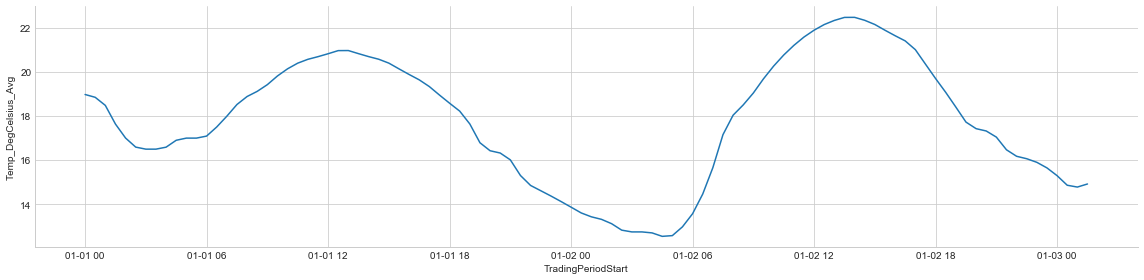

In [34]:
# Quick look at the interpolated and aggregated temperature
plot = sns.FacetGrid(temp_df.head(100), height=4, aspect=4)
plot.map(plt.plot, 'TradingPeriodStart', 'Temp_DegCelsius_Avg')

In [35]:
meter_df = meter_df.where(meter_df['TradingPeriod'] <= 48).dropna()
# Combining the MeterPollDateKey and TradingPeriod features into a TradingPeriodStart datetime feature
meter_df['TradingPeriodStart'] = (meter_df['MeterPollDateKey'].astype(int).astype(str) 
                        + ((meter_df['TradingPeriod']-1)/2).astype(int).astype(str).str.zfill(2) 
                        + (((meter_df['TradingPeriod']-1)%2)*30).astype(int).astype(str).str.zfill(2))
meter_df = meter_df.where(meter_df['TradingPeriod'] <= 48).dropna() # Droping the values were there are more then48 trading perdiods from daylight savings
meter_df['TradingPeriodStart'] = pd.to_datetime(meter_df['TradingPeriodStart'], format='%Y%m%d%H%M')

In [36]:
# Merging the meter dataframe and the interpolated and aggregated temperature dataframes
df = pd.merge(meter_df, temp_df, how='inner', on=['TradingPeriodStart'])

In [37]:
df.where(df.TradingPeriod == 24).dropna()

,ICPKey,MeterPollDateKey,TradingPeriod,ElecCons_kWh,Date,Season,Season_Int,Weekday_Int,Weekday,Weekend,Month_Int,Month,TradingPeriodStart,Temp_DegCelsius_Avg
1150,5972076.0,20150101.0,24.0,0.1700,2015-01-01,Summer,0.0,3.0,Thursday,0.0,1.0,Jan,2015-01-01 11:30:00,20.689932
1151,5976985.0,20150101.0,24.0,0.3720,2015-01-01,Summer,0.0,3.0,Thursday,0.0,1.0,Jan,2015-01-01 11:30:00,20.689932
1152,5981694.0,20150101.0,24.0,0.0560,2015-01-01,Summer,0.0,3.0,Thursday,0.0,1.0,Jan,2015-01-01 11:30:00,20.689932
1153,5981696.0,20150101.0,24.0,0.4400,2015-01-01,Summer,0.0,3.0,Thursday,0.0,1.0,Jan,2015-01-01 11:30:00,20.689932
1154,5987340.0,20150101.0,24.0,0.3300,2015-01-01,Summer,0.0,3.0,Thursday,0.0,1.0,Jan,2015-01-01 11:30:00,20.689932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874661,6440160.0,20151231.0,24.0,0.4199,2015-12-31,Summer,0.0,3.0,Thursday,0.0,12.0,Dec,2015-12-31 11:30:00,23.328128
874662,6561922.0,20151231.0,24.0,0.5270,2015-12-31,Summer,0.0,3.0,Thursday,0.0,12.0,Dec,2015-12-31 11:30:00,23.328128
874663,6562044.0,20151231.0,24.0,0.6769,2015-12-31,Summer,0.0,3.0,Thursday,0.0,12.0,Dec,2015-12-31 11:30:00,23.328128
874664,6564190.0,20151231.0,24.0,0.3440,2015-12-31,Summer,0.0,3.0,Thursday,0.0,12.0,Dec,2015-12-31 11:30:00,23.328128


## 8.4. Electricity Consumption Difference Calculation
---

##### Calculation the difference in consumption from summer to winter.
The 'Consumption Profile by Month' figure in section 7.1 indicates that the difference in consumption between summer and winter is grater then that between any other months so cooling costs might not be a significant factor for all households.

In [38]:
temp_avg_df = pd.DataFrame(df.groupby(['Season', 'ICPKey'])['Temp_DegCelsius_Avg'].mean())
temp_avg_df.reset_index(level=['Season', 'ICPKey'], inplace=True)
elec_cons_df = pd.DataFrame(df.groupby(['Season', 'ICPKey'])['ElecCons_kWh'].sum())
elec_cons_df.reset_index(level=['Season', 'ICPKey'], inplace=True)

In [39]:
difference_df = pd.merge(temp_avg_df, elec_cons_df, how='inner', on=['Season', 'ICPKey'])

In [40]:
difference_df = difference_df.pivot(index='ICPKey', columns='Season')
difference_df['ElecConsDiff_kWh'] = difference_df['ElecCons_kWh']['Winter'] - difference_df['ElecCons_kWh']['Summer']

In [41]:
difference_df.sort_values(by=['ElecConsDiff_kWh'], ascending=False).head(5)

Temp_DegCelsius_Avg                       ElecCons_kWh             \
Season                  Other     Summer     Winter        Other     Summer   
ICPKey                                                                        
6016524.0           15.091140  19.608848  11.214655    5759.3301  1778.3513   
6406908.0           15.090812  19.608848  11.214655    6857.3035  1724.1918   
6015713.0           15.089912  19.608848  11.214655    4258.2137  1470.2682   
6113779.0           15.091140  19.608848  11.214655    6055.0960  2118.1748   
6562044.0           15.090812  19.608848  11.214655    4348.9005  1869.6335   

                     ElecConsDiff_kWh  
Season        Winter                   
ICPKey                                 
6016524.0  5034.8621        3256.5108  
6406908.0  4785.2017        3061.0099  
6015713.0  4146.1230        2675.8548  
6113779.0  4604.6133        2486.4385  
6562044.0  4328.4197        2458.7862

##### This shows that the top 5 (or 10% of the sample) of housholds indicating that they would have the most potential to reduce consumption assuming all costs are related to heating and the differnece from winter to summer gives a compleate profile.
##### This would suggest that the households that should be given insulation are those similar to the ones with the ICPKeys:
- 6016524
- 6406908
- 6015713
- 6113779
- 6562044

#### However if we take a look at the other end of the sample we see:

In [42]:
difference_df.sort_values(by=['ElecConsDiff_kWh'], ascending=False).tail(5)

Temp_DegCelsius_Avg                       ElecCons_kWh             \
Season                  Other     Summer     Winter        Other     Summer   
ICPKey                                                                        
6416606.0           15.091140  19.608848  11.214655    1977.9320   823.6776   
6069096.0           15.089912  19.608848  11.214655    1353.7076   660.1541   
6069807.0           15.091140  19.608848  11.214655     709.8404   370.1890   
6416107.0           15.091140  19.608848  11.214655    5739.3662  3065.6369   
6033299.0           15.090812  19.608848  11.214655    2218.1344  1539.7842   

                     ElecConsDiff_kWh  
Season        Winter                   
ICPKey                                 
6416606.0  1009.8961         186.2185  
6069096.0   698.8681          38.7140  
6069807.0   340.1604         -30.0286  
6416107.0  2831.3975        -234.2394  
6033299.0   611.6543        -928.1299

##### Households with the lowest difference in consumption from summer to winter we see -ve values. This suggest that there are some households that only use electricity for cooling and little to no heating along with the fact that autumn and spring were ignored.
#### Indicating that this is perhaps an overly naive solution!

## 8.5. Modelled Dependence Of Consumption On Temperature
---

##### For a less naive solution im going to model the electricity consumption for each ICP key using a random forest (a simple yet powerful and robust algorithm). The SHAP (SHapley Additive exPlanations) values can then be used to identify the average impact on electricity consumption attributed to the outside temperature.

The shap git repo can be found here: https://github.com/slundberg/shap.
A full description of how shap values can be used to interpret the impact of variables on a model was written by Dr.Dataman and can be found here: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d.

In [81]:
# Creating a modelling dataframe (it's a very limited selection of features but for this eval it will have to do).
model_df = df[['Temp_DegCelsius_Avg', 'TradingPeriod', 'ElecCons_kWh', 'Season_Int', 'Weekday_Int', 'Weekend', 'Month_Int',]]
# Selecting a sub sample to speed up SHAP value calculation
model_df.sample(frac=0.1)

##### Quickly looking at the shap impacts on a single household.

Random Forest Regressor fit
Fold  1 RMSE : 0.211686
Fold  2 RMSE : 0.207527
Fold  3 RMSE : 0.218869
Fold  4 RMSE : 0.221716
Fold  5 RMSE : 0.221913
RMSE over folds: 0.216419


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


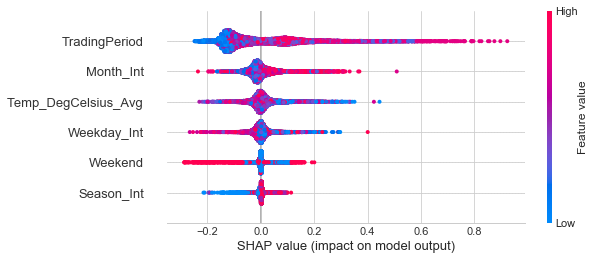

In [82]:
# Selecting a single ICPKey
single_key_df = model_df.where(df.ICPKey == 6416606).dropna()

# Fitting a random forrest regressor
RF = RandomForestRegressor(n_estimators=10, random_state=42)
RMSE, ExpElecCons_kWh, model = model_fit(RF, 'Random Forest Regressor', single_key_df, 'ElecCons_kWh')

# Calculating and plotting the shap values
X = single_key_df[['Temp_DegCelsius_Avg', 'TradingPeriod', 'Season_Int', 'Weekday_Int', 'Weekend', 'Month_Int']]
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

##### The above indicates that, for at least some households, the tempreture is a very significant factor.

In [84]:
# Random Forest Regressor
# Please note that for the purposes of this quick analysis no attempt has been made to optimise the hyperparameters or try different algorithms.
# Optimising the model is recomended as a better fit leads to more confidence in the shap values explanation.
RF = RandomForestRegressor(n_estimators=10, random_state=42)

array([5972076., 5976985., 5981694., 5981696., 5987340., 5987572.,
       5989238., 5990931., 6003265., 6007833., 6012464., 6014173.,
       6015713., 6015746., 6016463., 6016489., 6016505., 6016516.,
       6016524., 6016963., 6022959., 6023022., 6023045., 6023639.,
       6032898., 6033299., 6040901., 6069096., 6069155., 6069178.,
       6069807., 6111971., 6113779., 6113799., 6115030., 6396289.,
       6400416., 6402389., 6402396., 6406799., 6406908., 6416107.,
       6416606., 6416980., 6435401., 6440160., 6561922., 6562044.,
       6564190., 6578393.])

In [ ]:
for ICPKey in df['ICPKey'].unique():
    single_key_df = model_df.where(df.ICPKey == ICPKey).dropna()
    avg_abs_impact = avg_abs_shap_value(RF, single_key_df, 'Temp_DegCelsius_Avg')
    print(f"ICP key: {int(ICPKey)}, Average Absolute Impact on Electricity Consumption Rate: {avg_abs_impact} kWh")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


ICP key: 5972076.0, Average Absolute Impact on Electricity Consumption: 0.14125333938321172
